### Classification using KNN

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
from sklearn.model_selection import train_test_split

In [2]:
# extract images from label directories into training and test sets
def extract_label_images(path,label,training_images,training_labels,train_value,test_images,test_labels,test_value):
    new_path = path + "/" +label
    train_count = 0
    test_count = 0
    
    ## resize images to 64x64 grayscale 
    for file in os.listdir(new_path):
    # grab only 10 images from label directory for testing purposes 
        if (train_count < train_value):
            img = cv2.cvtColor(cv2.imread(os.path.join(new_path+ "/" +file)), cv2.COLOR_BGR2GRAY)
            #print(img.shape)
            img = cv2.resize(img,(64,64))
            training_images.append(img)
            training_labels.append(label)
            train_count = train_count + 1 
            
        elif (test_count < test_value):
            img = cv2.cvtColor(cv2.imread(os.path.join(new_path+ "/" +file)), cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img,(64,64))
            test_images.append(img)
            test_labels.append(label)
            test_count = test_count + 1 
        else:
            break
            
    print("FINISH EXTRACTING LABEL : ", label)
    print("NUMBER OF SAMPLE FOR LABEL :", train_count)
    return training_images,test_images


In [6]:
def extractLabels(path):
    label_list = []
    for file in os.listdir(path):
        label_list.append(""+file)
    return label_list


In [4]:
def getHogFeatures(images):
    cell_size = (4, 4)  # h x w in pixels
    block_size = (4, 4)  # h x w in cells
    nbins = 8  # number of orientation bins
    
    hog = cv2.HOGDescriptor(_winSize=(images[0].shape[1] // cell_size[1] * cell_size[1],
                                          images[0].shape[0] // cell_size[0] * cell_size[0]),
                                _blockSize=(block_size[1] * cell_size[1],
                                            block_size[0] * cell_size[0]),
                                _blockStride=(cell_size[1], cell_size[0]),
                                _cellSize=(cell_size[1], cell_size[0]),
                                _nbins=nbins)
    
    n_cells = (images[0].shape[0] // cell_size[0], images[0].shape[1] // cell_size[1])
    
    listOfHogFeatures = []
    for img in images:
        # create HoG Object
        # winSize is the size of the image cropped to an multiple of the cell size
        

        # Compute HoG features
        hog_feats = hog.compute(img)\
                       .reshape(n_cells[1] - block_size[1] + 1,
                                n_cells[0] - block_size[0] + 1,
                                block_size[0], block_size[1], nbins) \
                       .transpose((1, 0, 2, 3, 4))  # index blocks by rows first

        # hog_feats now contains the gradient amplitudes for each direction,for each cell of its group for each group.
        # Indexing is by rows then columns.
        # computation for BlockNorm
        gradients = np.full((n_cells[0], n_cells[1], 8), 0, dtype=float)
        cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

        for off_y in range(block_size[0]):
            for off_x in range(block_size[1]):
                gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                          off_x:n_cells[1] - block_size[1] + off_x + 1] += \
                    hog_feats[:, :, off_y, off_x, :]
                cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                           off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

        # Average gradients
        gradients /= cell_count
        # turn gradient 32,32,8 3D array to 1D for training 
        reshaped_gradients = gradients.ravel()
        listOfHogFeatures.append(reshaped_gradients)
        
    return listOfHogFeatures


In [5]:
training_set_path= r"./MIO-TCD-Classification/train"
labels = extractLabels(training_set_path)
train_images = []
train_labels = []
train_value = 5000

test_images = []
test_labels = []
test_value = 1

## Extracting 64x64 gray scale images from each label directory
for label in labels:
    extract_label_images(training_set_path, label, train_images, train_labels, train_value, test_images, test_labels, test_value)

print(len(train_images))
print(len(train_labels))
print(len(test_images))
print(len(test_labels))


FINISH EXTRACTING LABEL :  articulated_truck
NUMBER OF SAMPLE FOR LABEL : 5000
FINISH EXTRACTING LABEL :  background
NUMBER OF SAMPLE FOR LABEL : 5000
FINISH EXTRACTING LABEL :  bicycle
NUMBER OF SAMPLE FOR LABEL : 2284
FINISH EXTRACTING LABEL :  bus
NUMBER OF SAMPLE FOR LABEL : 5000
FINISH EXTRACTING LABEL :  car
NUMBER OF SAMPLE FOR LABEL : 5000
FINISH EXTRACTING LABEL :  motorcycle
NUMBER OF SAMPLE FOR LABEL : 1982
FINISH EXTRACTING LABEL :  non-motorized_vehicle
NUMBER OF SAMPLE FOR LABEL : 1751
FINISH EXTRACTING LABEL :  pedestrian
NUMBER OF SAMPLE FOR LABEL : 5000
FINISH EXTRACTING LABEL :  pickup_truck
NUMBER OF SAMPLE FOR LABEL : 5000
FINISH EXTRACTING LABEL :  single_unit_truck
NUMBER OF SAMPLE FOR LABEL : 5000
FINISH EXTRACTING LABEL :  work_van
NUMBER OF SAMPLE FOR LABEL : 5000
46017
46017
8
8


In [5]:
## extract hog features of each images of labels 
training_img_features = getHogFeatures(train_images)

2048


In [6]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3, n_jobs = 4)

### Cross validation

In [7]:
training_img_features = np.array(training_img_features)
train_labels = np.array(train_labels)
# randomize training set.
X_train, X_test, label_train, Y_test = train_test_split(training_img_features, train_labels, train_size=0.99, test_size=0.01)
print(X_train.shape)
print(X_test.shape)
print(label_train.shape)
print(Y_test.shape)


(45556, 2048)
(461, 2048)
(45556,)
(461,)


In [8]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

kf_splitter = KFold(n_splits=10)

valid_label_prediction_accuracy = []
valid_label_prediction_precision = []
valid_label_prediction_recall = []

# kfold cross validation
for train_index, valid_index in kf_splitter.split(X_train):

    train_set = X_train[train_index, :]
    t_label = label_train[train_index]
    
    # Get our validation data in this fold
    valid_set = X_train[valid_index, :]
    v_label = label_train[valid_index]
    
    # Train KNN Classfier
    model.fit(train_set, t_label)
    
    # Get our prediction for validation:
    prediction_valid = model.predict(valid_set)
    
    accuracy = accuracy_score(v_label, prediction_valid)
    print("ACCURACY :", accuracy)
    valid_label_prediction_accuracy.append(accuracy)
    
    precision = precision_score(v_label, prediction_valid, average='micro')
    print("PRECISION :", precision)
    valid_label_prediction_precision.append(precision)
    
    recall = recall_score(v_label, prediction_valid, average='micro')
    print("RECALL : ", recall)
    valid_label_prediction_recall.append(recall)
    
print("ACCURACY DATA : ")
print(valid_label_prediction_accuracy)
print("PRECISION DATA : ")
print(valid_label_prediction_precision)
print("RECALL : ")
print(valid_label_prediction_recall)

ACCURACY : 0.7684372256365233
PRECISION : 0.7684372256365233
RECALL :  0.7684372256365233
ACCURACY : 0.7570237050043899
PRECISION : 0.7570237050043899
RECALL :  0.7570237050043899
ACCURACY : 0.754828797190518
PRECISION : 0.754828797190518
RECALL :  0.754828797190518
ACCURACY : 0.7456101843722563
PRECISION : 0.7456101843722563
RECALL :  0.7456101843722563
ACCURACY : 0.7480245829675154
PRECISION : 0.7480245829675154
RECALL :  0.7480245829675154
ACCURACY : 0.7561457418788411
PRECISION : 0.7561457418788411
RECALL :  0.7561457418788411
ACCURACY : 0.7554335894621296
PRECISION : 0.7554335894621296
RECALL :  0.7554335894621296
ACCURACY : 0.7523600439077937
PRECISION : 0.7523600439077937
RECALL :  0.7523600439077937
ACCURACY : 0.750384193194292
PRECISION : 0.750384193194292
RECALL :  0.750384193194292
ACCURACY : 0.748847420417124
PRECISION : 0.748847420417124
RECALL :  0.748847420417124
ACCURACY DATA : 
[0.7684372256365233, 0.7570237050043899, 0.754828797190518, 0.7456101843722563, 0.7480245829

In [9]:
print("AVERAGE ACCURACY SCORE : ", str(np.mean(valid_label_prediction_accuracy) * 100) + " %")
print("STANDARD DEVIATION : ", str(np.std(valid_label_prediction_accuracy) * 100) + " %")
print("AVERAGE RECALL SCORE : ", str(np.mean(valid_label_prediction_recall) * 100) + " %")
print("AVERAGE PRECISION SCORE : ", str(np.mean(valid_label_prediction_precision) * 100) + " %")

AVERAGE ACCURACY SCORE :  75.37095484031383 %
STANDARD DEVIATION :  0.6103164364900331 %
AVERAGE RECALL SCORE :  75.37095484031383 %
AVERAGE PRECISION SCORE :  75.37095484031383 %


### Confusion matrix

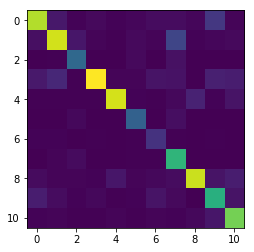

In [10]:

from sklearn.metrics import confusion_matrix
conf = confusion_matrix(prediction_valid, v_label)
plt.figure()
plt.imshow(conf)

In [ ]:
## SAVING MODEL

from sklearn.externals import joblib
joblib.dump(model, 'filename.pk1')